# Regression of Product Prices Using a GBM

## By: ZXS107020

### Introduction-

Gradient Boosted Machines are gaining popularity within the data science community. There are many reasons for this. The most important among these is perhaps the fact that GBM's build decision trees through an iterative process as opposed to randomly. This feature allows the GBM to provide more expressive results than a normal random forest. 

These methods are most commonly used for classification tasks. The generalized method is well-suited for handling categorical outcomes that are not continuous in nature. However, for our purposes we are going to go ahead and test this methodology on a problem in which the target variable is in fact continuous. Due to the nature of our target variable, we will not be able to rely on traditional methods of model validation such as classification accuracy or the sensitivity/specificity. Instead we will use the RMSE or root mean squared error. This will make our model a little harder to judge because this is a relative measure, but generally speaking- the smaller the RMSE the better the model. 

In any case, lets get started.  

***

### Pre-Processing

In [1]:
# Import the required libraries
import os
import zipfile
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import csr_matrix, hstack
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [8]:
# Set the URL for data and local destination
wd = '/Users/zansadiq/Documents/Code/local/Misc'
fn = 'mercari.zip'

In [9]:
# Change the working directory
os.chdir(wd)

In [10]:
# Access the Data and Unzip
with zipfile.ZipFile(fn, 'r') as zf:
    zf.extractall()

# Load the training set
training = pd.read_csv('train.tsv', sep = '\t')

# Load the testing set
testing = pd.read_csv('test.tsv', sep = '\t')

In [11]:
# Check for missing values
training.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [12]:
testing.isnull().sum()

test_id                   0
name                      0
item_condition_id         0
category_name          3058
brand_name           295525
shipping                  0
item_description          0
dtype: int64

In [13]:
# Handle nulls
training['category_name'].fillna(value = 'missing', inplace = True)
training['brand_name'].fillna(value = 'missing', inplace = True)
training['item_description'].fillna(value = 'missing', inplace = True)

testing['category_name'].fillna(value = 'missing', inplace = True)
testing['brand_name'].fillna(value = 'missing', inplace = True)
testing['item_description'].fillna(value = 'missing', inplace = True)

In [14]:
# Transform categorical variables
def to_cat(data, col):
    data[col] = data[col].astype('category')
    return data

cols = ['category_name', 'brand_name', 'item_condition_id']

for i in cols:
    to_cat(training, i)
    to_cat(testing, i)

In [15]:
# Drop 0 prices
training = training[training.price != 0].reset_index(drop = True)  

In [16]:
# Separate dependent variables
y_training = training['price']

training = training.drop('price', axis = 1)

***

### Modeling

Before we go any further, it is important to note: the testing data in this example is unlabeled. As a result, we would have no way of measuring the accuracy of our price predictions. Instead, what we will do is rely on only the training data. We will divide this information into two sets with a 70/30 split to create a validation set. This will allow us to measure the RMSE and determine how our predictions stack up against the actual prices in the labeled set.

In [17]:
# Split the training data for validation
train_x, val_x, train_y, val_y = model_selection.train_test_split(training, y_training, test_size = .3, random_state = 100)

In [18]:
# General settings for GBM model
num_hotel = 879
num_cat = 1000
name_min_df = 10
max_ft = 50000

#### Count Vectorization: Converting Categorical Variables

In [19]:
# Vectorize the products and categories
cv = CountVectorizer(min_df = name_min_df)

x_train_name = cv.fit_transform(train_x['name'])
x_test_name = cv.fit_transform(val_x['name'])

cv = CountVectorizer()

x_train_cat = cv.fit_transform(train_x['category_name'])
x_test_cat = cv.fit_transform(val_x['category_name'])

#### TF-IDF: Creating a Measure of Importance for Item Descriptions

In [20]:
# TF-IDF
tv = TfidfVectorizer(max_features = max_ft, ngram_range = (1, 3), stop_words = 'english')

x_train_desc = tv.fit_transform(train_x['item_description'])
x_test_desc = tv.fit_transform(val_x['item_description'])

***

In [21]:
# Binarize labels
lb = LabelBinarizer(sparse_output = True)

x_train_brand = lb.fit_transform(train_x['brand_name'])
x_test_brand = lb.fit_transform(val_x['brand_name'])

In [22]:
# Dummy variables for item_condition_id and shipping
x_training_dummies = csr_matrix(pd.get_dummies(train_x[['item_condition_id', 'shipping']], sparse = True).values)
x_testing_dummies = csr_matrix(pd.get_dummies(val_x[['item_condition_id', 'shipping']], sparse = True).values)

In [23]:
# Merge
training_merged = hstack((x_training_dummies, x_train_desc, x_train_brand, x_train_cat, x_train_name)).tocsr()
testing_merged = hstack((x_testing_dummies, x_test_desc, x_test_brand, x_test_cat, x_test_name)).tocsr()

In [24]:
# Remove doc frequencies < 1
mask = np.array(np.clip(training_merged.getnnz(axis = 0) - 1, 0, 1), dtype = bool)
test_mask = np.array(np.clip(testing_merged.getnnz(axis = 0) - 1, 0, 1), dtype = bool)

training_merged = training_merged[:, mask]
testing_merged = testing_merged[:, test_mask]

***

In [25]:
# GBM
train_x = lgb.Dataset(training_merged, label = train_y)

In [26]:
# Parameters (these can be fine-tuned)
params = {'learning_rate': .75, 'application': 'regression', 'max_depth': 3, 'num_leaves': 100, 'verbosity': -1, 'metric': 'RMSE'}

***

### Results and Visuals

Well folks, thats all there is to it. We have successfully preprocessed a dataset of product prices and descriptions and prepared this information for modeling via a "Gradient Boosted Machine". Unfortunately, we will not be able to truly judge how accurate our model was because of the unlabelled training data as well as the fact that regression tasks often do not have an associated measure for measuring absolute performance. 

In any case, we can still get a good idea of how we did by looking at the pricing distributions and comparing these results to the training data.

In [27]:
# Train model
gbm = lgb.train(params, train_set = train_x, num_boost_round = 3200, verbose_eval = 100)

In [28]:
# Predictions
test_preds = gbm.predict(testing_merged, num_iteration = gbm.best_iteration)

In [29]:
# Evaluate 
print('The RMSE of the GBM Predictions is: ', mean_squared_error(val_y, test_preds))

The RMSE of the GBM Predictions is:  2185.6846719083246


Text(0.5,1,'Price Distribution')

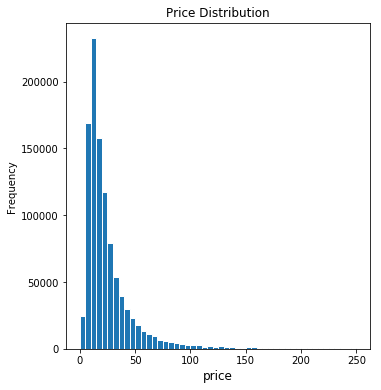

In [30]:
# Visualize training data
plt.subplot(1, 2, 1)
(train_y).plot.hist(bins = 50, figsize = (12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize = 12)
plt.title('Price Distribution', fontsize = 12)

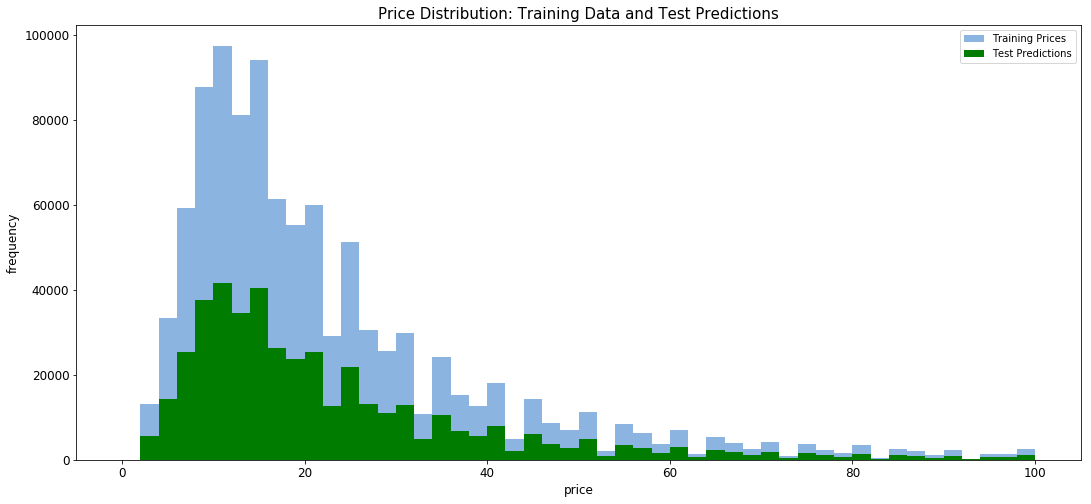

In [31]:
# Compare training distribution to test results
fig, ax = plt.subplots(figsize = (18, 8))

ax.hist(train_y, color = '#8CB4E1', bins = 50, range = [0, 100], label = 'Training Prices')
ax.hist(val_y, color = '#007D00', bins = 50, range = [0, 100], label = 'Test Predictions')
        
plt.xlabel('price', fontsize = 12)
plt.ylabel('frequency', fontsize = 12)

plt.title('Price Distribution: Training Data and Test Predictions', fontsize = 15)

plt.tick_params(labelsize = 12)

plt.legend()

plt.show()

***

### Improving Model  

Our next task is to see if we cant somehow improve upon the results that we have achieved with our GBM model. We will evaluate the performance of our fine-tuning using the amount by which we can reduce the RMSE of our initial results.  

Enter TPOT: 

A popular new trend in the field of data science is the use of automated machine learning. There are various packages that have been developed for this purpose. The one that we will use here is TPOT. 

TPOT works by interfacing with `sci-kit learn` by exploring possible "pipelines" automatically. 

![TPOT Framework](https://github.com/EpistasisLab/tpot/blob/master/images/tpot-ml-pipeline.png?raw=true)

After the package has performed an exhaustive search of different algorithms and tuning parameters, it then selects the model with the highest performance and generates a file of python code in which it stores the model. 

A general outline of the procedure is provided below:

![TPOT Modeling Process](https://github.com/EpistasisLab/tpot/blob/master/images/tpot-pipeline-example.png?raw=true).

***

Now lets go ahead and write the code-

In [34]:
# Import the required libraries
from tpot import TPOTRegressor

In [35]:
# Initialize the TPOT model
tpot = TPOTRegressor(generations = 5, population_size = 20, verbosity = 2, n_jobs = 4)

In [ ]:
# Convert the data to dense matrices for modeling
tpot_train = training_merged.todense()
tpot_test = testing_merged.todense()

# Convert matrices to arrays
tpot_training = tpot_train.A1
tpot_testing = tpot_test.A1

In [ ]:
# Fit the model
tpot.fit(tpot_training, train_y)

In [ ]:
# Results
print(tpot.score(tpot_testing, val_y))

In [ ]:
# Export code
tpot.export('tpot_price_regression.py')